In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
%matplotlib inline

# Load and prepare data
data = pd.read_csv('data.csv')

In [2]:
# Reshape data
monthly_data = pd.melt(data, id_vars=['ITEM DESCRIPTION'],
                       value_vars=[col for col in data.columns if 'JANUARY' in col or 'FEBRUARY' in col or 'MARCH' in col or 'APRIL' in col or 'MAY' in col or 'JUNE' in col or 'JULY' in col or 'AUGUST' in col or 'SEPTEMBER' in col or 'OCTOBER' in col or 'NOVEMBER' in col or 'DECEMBER' in col],
                       var_name='Month_Year', value_name='Consumption')

# Extract year and month
monthly_data['Year'] = monthly_data['Month_Year'].str.split('_').str[1]
monthly_data['Month'] = monthly_data['Month_Year'].str.split('_').str[0]

# Create a date column
monthly_data['Date'] = pd.to_datetime(monthly_data['Month'] + ' ' + monthly_data['Year'], format='%B %Y')

# Drop unnecessary columns
monthly_data = monthly_data.drop(columns=['Month_Year'])

# Sort by date
monthly_data = monthly_data.sort_values(by='Date')

# Set Date as index
monthly_data.set_index('Date', inplace=True)

# Display the first few rows of the reshaped data
monthly_data.head()

,ITEM DESCRIPTION,Consumption,Year,Month
Date,,,,
2019-01-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,4,2019,JANUARY
2019-01-01,Ringer Lactate - Compound Sodium Lactate Injec...,119,2019,JANUARY
2019-01-01,Ring File 79,33,2019,JANUARY
2019-01-01,Ribbon Gauze Non-Sterile (VAGINAL Pack) 5m x 5...,6,2019,JANUARY
2019-01-01,Ribbon Gauze Non-Sterile (ENT Pack) 5m x 1.25c...,0,2019,JANUARY


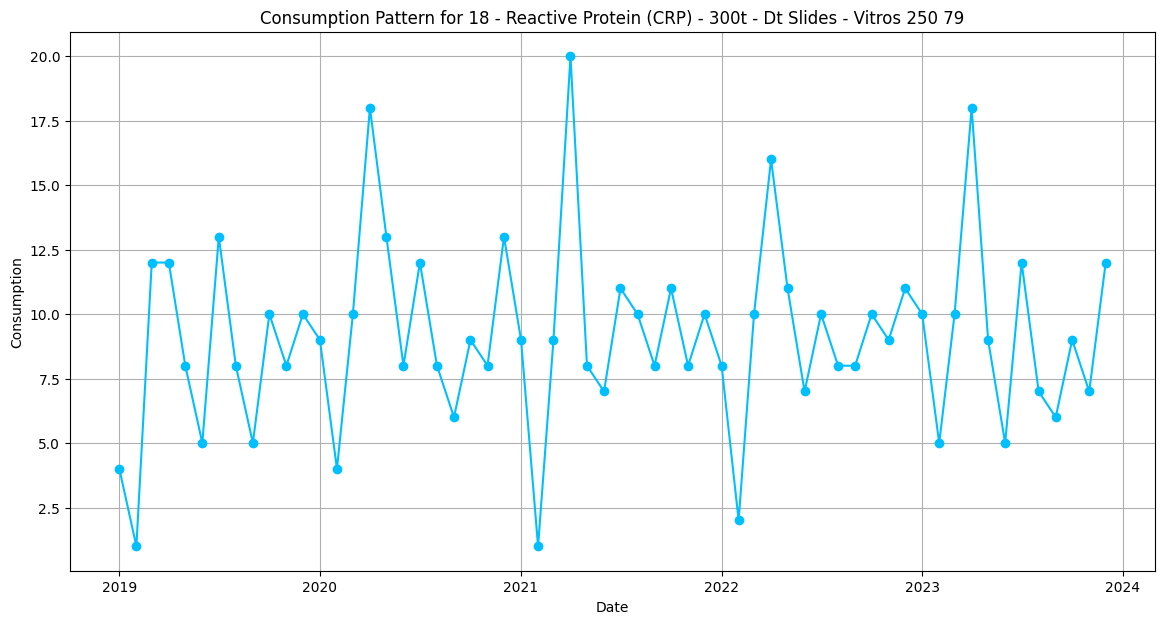

In [3]:
# Plot consumption patterns for a sample item
sample_item = monthly_data['ITEM DESCRIPTION'].unique()[0]
sample_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == sample_item]

plt.figure(figsize=(14, 7))
plt.plot(sample_data.index, sample_data['Consumption'], marker='o', linestyle='-', color='deepskyblue' )
plt.title(f'Consumption Pattern for {sample_item}')
plt.xlabel('Date')
plt.ylabel('Consumption')
plt.grid(True)
plt.show()

In [4]:
# Prepare for each item
items = monthly_data['ITEM DESCRIPTION'].unique()

future_predictions_all_items = []


In [5]:
for item in items:
    # Filter data for the current item
    item_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == item].copy()

    # Fit SARIMA model
    try:
        model = SARIMAX(item_data['Consumption'], order=(1, 1, 1), seasonal_order=(0, 1, 1, 12))
        sarima_model = model.fit(disp=False)

        # Forecast next 12 months
        future_dates = pd.date_range(start=item_data.index.max() + pd.DateOffset(months=1), periods=12, freq='MS')
        forecast = sarima_model.get_forecast(steps=12)
        forecast_values = forecast.predicted_mean

        # Create DataFrame for future predictions
        future_df = pd.DataFrame({'Date': future_dates, 'Item': item, 'Predicted_Consumption': forecast_values})
        future_predictions_all_items.append(future_df)

    except Exception as e:
        print(f"Error processing item {item}: {e}")

# Combine all future predictions into a single DataFrame
final_predictions = pd.concat(future_predictions_all_items)

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.

In [6]:
# Save predictions to CSV
final_predictions.to_csv('sarima_predictions.csv', index=False)
print("Predictions saved to 'sarima_predictions.csv'")

# Display the first few rows of the predictions
final_predictions.head()

Predictions saved to 'sarima_predictions.csv'


,Date,Item,Predicted_Consumption
2024-01-01,2024-01-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,8.098450
2024-02-01,2024-02-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,2.737334
2024-03-01,2024-03-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,10.335904
2024-04-01,2024-04-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,16.936106
2024-05-01,2024-05-01,18 - Reactive Protein (CRP) - 300t - Dt Slides...,9.935973


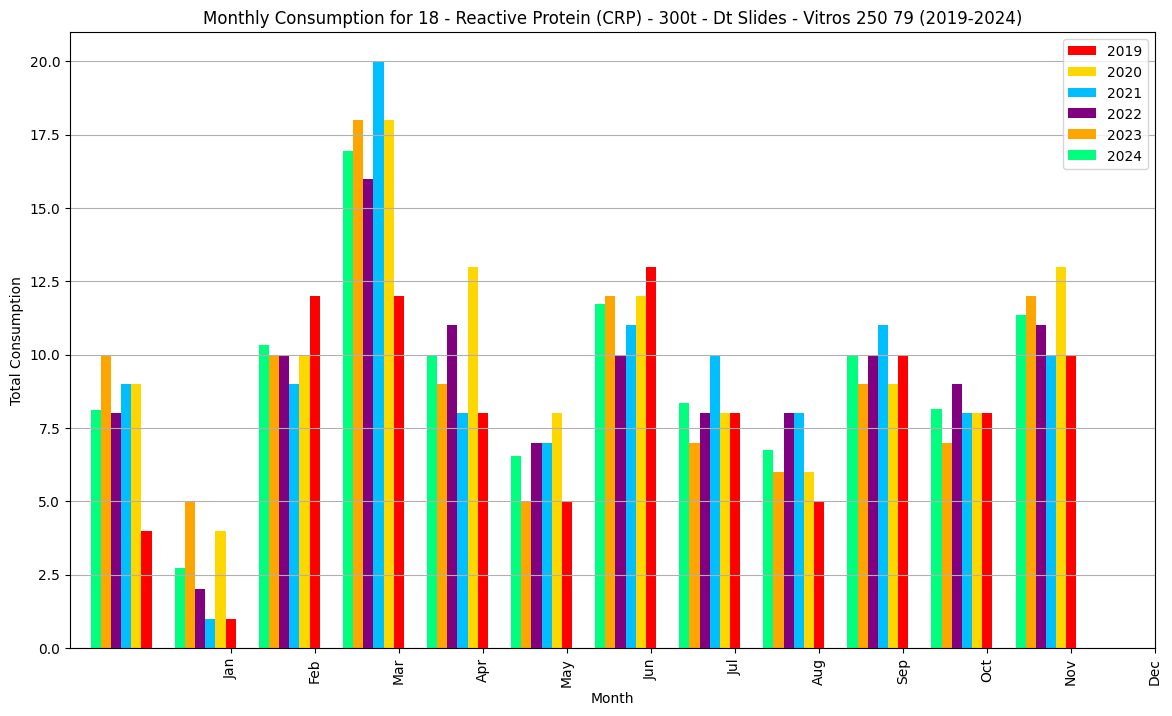

In [7]:
# Select a specific item for detailed analysis
specific_item = items[0]

# Historical data for the specific item
historical_data = monthly_data[monthly_data['ITEM DESCRIPTION'] == specific_item].copy()

# Predicted data for the specific item
predicted_data = final_predictions[final_predictions['Item'] == specific_item].copy()

# Add year and month columns to historical data
historical_data['Year'] = historical_data.index.year
historical_data['Month'] = historical_data.index.month

# Add year and month columns to predicted data
predicted_data['Year'] = predicted_data['Date'].dt.year
predicted_data['Month'] = predicted_data['Date'].dt.month

# Plot the bar graph
plt.figure(figsize=(14, 8))

# Define width and positions
bar_width = 0.12
months = range(1, 13)


# Historical data for 2019
hist_2019 = historical_data[historical_data['Year'] == 2019].groupby('Month')['Consumption'].sum()
hist_2019.plot(kind='bar', color='red', position=0.5, width=bar_width, label='2019', align='center')

# Historical data for 2020
hist_2020 = historical_data[historical_data['Year'] == 2020].groupby('Month')['Consumption'].sum()
hist_2020.plot(kind='bar', color='gold', position=1.5, width=bar_width, label='2020', align='center')

# Historical data for 2021
hist_2021 = historical_data[historical_data['Year'] == 2021].groupby('Month')['Consumption'].sum()
hist_2021.plot(kind='bar', color='deepskyblue', position=2.5, width=bar_width, label='2021', align='center')

# Historical data for 2022
hist_2022 = historical_data[historical_data['Year'] == 2022].groupby('Month')['Consumption'].sum()
hist_2022.plot(kind='bar', color='purple', position=3.5, width=bar_width, label='2022', align='center')

# Historical data for 2023
hist_2023 = historical_data[historical_data['Year'] == 2023].groupby('Month')['Consumption'].sum()
hist_2023.plot(kind='bar', color='orange', position=4.5, width=bar_width, label='2023', align='center')

# Predicted data for 2024
pred_2024 = predicted_data[predicted_data['Year'] == 2024].groupby('Month')['Predicted_Consumption'].sum()
pred_2024.plot(kind='bar', color='springgreen', position=5.5, width=bar_width, label='2024', align='center')

plt.title(f'Monthly Consumption for {specific_item} (2019-2024)')
plt.xlabel('Month')
plt.ylabel('Total Consumption')
plt.legend()
plt.xticks(months, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')
plt.show()